### Keras Tutorial on Dogs vs Cats

We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

NOTE: We can run this or similar models on a cloud service Paperspace if we don't have the processing power.
It's like $10-$15 a month.
https://www.paperspace.com/

This example uses Resnet50. It is really powerful. For 2 classes and about 2000 images this works gets about 95% accuracy. However, Karan recommends pytorch over Keras for more complicated projects. If we dont' need anything too complicated we can just use Keras because it is a bit simpler.

For the Barrels and jersey barriers example, we can use YOLO or SSD. This is inherently a different task than what is shown here. Here we are doing classification for the barriers and barrels example we want to do detection.

Here we import the libraries we need. We'll learn about what each does during the course.

In [58]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
PATH = "data/dogscats/"
sz=224
batch_size=64

In [60]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
import os
from matplotlib import pyplot as plt

In [61]:
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'

Let's first look at some Cat pictures — my favorite part!

In [62]:
os.listdir(PATH)

['train', 'valid']

In [63]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [64]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.1000.jpg',
 'cat.1001.jpg',
 'cat.1002.jpg',
 'cat.1003.jpg',
 'cat.1004.jpg']

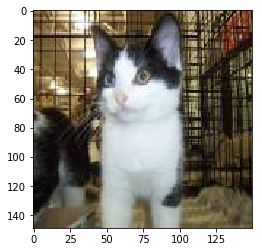

In [65]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [66]:
img.shape

(149, 150, 3)

In [67]:
img[:4,:4]

array([[[140, 112,  75],
        [140, 112,  75],
        [144, 116,  79],
        [146, 118,  81]],

       [[136, 108,  71],
        [137, 109,  72],
        [143, 115,  78],
        [146, 118,  81]],

       [[114,  88,  53],
        [116,  90,  55],
        [124,  98,  63],
        [127, 101,  66]],

       [[ 91,  67,  33],
        [ 93,  69,  35],
        [101,  77,  43],
        [103,  79,  45]]], dtype=uint8)

In [68]:
# We are generating images for training at run time from imagenet, shearing them etc.,
# Can save memory space on your computer
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

Found 2048 images belonging to 2 classes.
Found 832 images belonging to 2 classes.


In [69]:
# for our simplified network, get rid of last layer so we can add our network at the end
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [70]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=3, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

In [71]:
# Only train the layers we added
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=1, workers=3,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/1
32/32 [==============================] - 775s 24s/step - loss: 0.3675 - acc: 0.9131 - val_loss: 0.0825 - val_acc: 0.9724
CPU times: user 1h 22min 9s, sys: 4min 19s, total: 1h 26min 29s
Wall time: 12min 57s
